### Import the required libraries


In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import torch
import numpy as np
import slim
import matplotlib.pyplot as plt
import seaborn as sns
from neuromancer import blocks, estimators, dynamics, integrators
from neuromancer.activations import activations
from neuromancer.trainer import Trainer
from neuromancer.problem import Problem
from neuromancer.dataset import get_sequence_dataloaders
from neuromancer.constraint import variable
from neuromancer.loss import PenaltyLoss
import neuromancer.simulator as sim
from neuromancer.loggers import BasicLogger
from sklearn.preprocessing import MinMaxScaler

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f'The device used for training is: {device}')

The device used for training is: cuda


### Import the raw dataset

In [2]:
df_data = pd.read_csv('house_data.csv')
df_data['Time'] = np.array([x for x in range(0,df_data.shape[0])])
display(df_data.head())

,Time,T01_TEMP,T02_TEMP,T03_TEMP,T04_TEMP,T05_TEMP,T06_TEMP,T07_TEMP,T08_TEMP,T09_TEMP,...,T01_Wh,T02_Wh,T03_Wh,T04_Wh,T05_Wh,T06_Wh,T07_Wh,T08_Wh,T09_Wh,GHI
0,0,17.786,18.351,19.061,19.091,19.214,18.784,19.581,19.188,19.963,...,0.0,1.0,1.0,4.0,6.0,2.0,2.0,2.0,2.0,0.0
1,1,17.394,17.925,18.571,18.596,18.803,17.706,19.052,18.727,19.381,...,82.0,2.0,2.0,4.0,7.0,2.0,2.0,2.0,2.0,0.0
2,2,17.389,17.613,18.063,18.095,18.339,17.974,18.444,18.237,18.902,...,415.0,35.0,2.0,4.0,7.0,2.0,2.0,2.0,2.0,0.0
3,3,17.540,17.567,17.588,17.642,17.915,16.647,17.877,17.759,18.408,...,497.0,123.0,2.0,42.0,7.0,2.0,2.0,25.0,2.0,0.0
4,4,17.667,17.603,17.278,17.337,17.573,17.612,17.376,17.482,18.001,...,432.0,304.0,2.0,206.0,6.0,92.0,157.0,178.0,2.0,0.0


### Prepare and preprocess the data

The predicted variables ($x$) and exogenous ($u$) variables are stacked in two different NumPy arrays and then normalized scaled between 0 and 1 (a good practice when manipulating NODEs). Note that all the data is normalized using only the 10 days training data. This is to avoid soiling the validation and both training sets with prior knowledge bias. 

Both arrays are then put in a dictionary to be sampled in batches and divided into training, validation and testing datasets.

In [4]:
u_array = np.column_stack((
                           df_data['T01_Wh'],
                           df_data['T02_Wh'],
                           df_data['T03_Wh'],
                           df_data['T04_Wh'],
                           df_data['T05_Wh'],
                           df_data['T06_Wh'],
                           df_data['T07_Wh'],
                           df_data['T08_Wh'],
                           df_data['T09_Wh'],
                           df_data['GHI'],
                           df_data['Text']
                           ))

u_scaler = MinMaxScaler(feature_range=(0, 1))
u_scaler.fit(u_array[:-145]) #145 for the 6 days of validation and testing
scaled_u_array = u_scaler.transform(u_array)

x_array = np.column_stack((df_data['T01_TEMP'],
                           df_data['T02_TEMP'],
                           df_data['T03_TEMP'],
                           df_data['T04_TEMP'],
                           df_data['T05_TEMP'],
                           df_data['T06_TEMP'],
                           df_data['T07_TEMP'],
                           df_data['T08_TEMP'],
                           df_data['T09_TEMP'],
                           ))

x_scaler = MinMaxScaler(feature_range=(0, 1))
x_scaler.fit(x_array[:-145]) #145 for the 6 days of validation and testing
scaled_x_array = x_scaler.transform(x_array)


time_array = np.column_stack((df_data['Time']))


raw = {}
raw['Y'] = scaled_x_array
raw['U'] = scaled_u_array

raw['Y'] = np.reshape(raw['Y'], (-1, scaled_x_array.shape[1]))
raw['U'] = np.reshape(raw['U'], (-1, scaled_u_array.shape[1]))

The model will make predictions over a 24 prediction horizon and the data is batched accordingly. Since the predicted temperatures are both the measurements and states, we will consider that the system is fully observable and that there is no difference between the measurements and the state of the system.

In [5]:
#  Train, Development, Test sets - nstep and loop format
nsteps = 24 # nsteps rollouts in training
# The split ratio here defines the train, validation and test datasets
nstep_data, loop_data, dims = get_sequence_dataloaders(raw, nsteps,
                            moving_horizon=True, split_ratio = [62.5,12.5],) #batch_size not used here 
train_data, dev_data, test_data = nstep_data
train_loop, dev_loop, test_loop = loop_data

nx = dims['Y'][1]
estim = estimators.FullyObservable(
    {**train_data.dataset.dims, "x0": (nx,)},
    linear_map=slim.maps['identity'],
    input_keys=["Yp"],
)
estim(train_data.dataset.get_full_batch())

{'x0_fully_observable': tensor([[0.1444, 0.2645, 0.3255,  ..., 0.5283, 0.3055, 0.4047],
         [0.0415, 0.1519, 0.2446,  ..., 0.4094, 0.2275, 0.3103],
         [0.0402, 0.0695, 0.1608,  ..., 0.2726, 0.1446, 0.2326],
         ...,
         [0.8939, 0.8859, 0.5503,  ..., 0.7202, 0.5849, 0.6389],
         [0.4769, 0.5400, 0.4862,  ..., 0.6401, 0.5156, 0.5748],
         [0.3251, 0.3847, 0.4347,  ..., 0.5623, 0.4400, 0.5086]]),
 'reg_error_fully_observable': tensor(0.)}

### Create Neuromancer model

The multi-layer perceptron, the integrator and its interpolator are instantiated. The loss for a prediction of index $k$ of batch number $i$ is denoted as:

$\begin{equation*}
\begin{align*}
\mathcal{L}_{x}=||x^{i}_{k}-\hat{x}^{i}_{k}||^{2}_{2}
\end{align*}
\end{equation*}$

And the objective function as:

$\begin{equation*}
\begin{align*}
\min_{\theta} \quad & \sum_{i=0}^{M}\left(\sum_{k=0}^{N}||x^{i}_{k}-\hat{x}^{i}_{k}||^{2}_{2}\right)\\
\textrm{s.t.} \quad & \hat{x}^{i}_{k+1} = \hat{x}^{i}_{k}+\int_{t_{k}}^{t_{k+1}} f_{\theta}\left(\hat{x}^{i}_{k},u^{i}_{k}\right)dt\\
\end{align*}
\end{equation*}$



In [40]:
# Instantiate the blocks, dynamics model in Neuromancer:
nx = dims['Y'][1]
nu = dims['U'][1]

def Interp_1D(tq,t,u):

    return u

interp_u = Interp_1D

black_box_ode = blocks.MLP(insize=nx+nu, outsize=nx, hsizes=[24,24],
                           linear_map=slim.maps['linear'],bias=True,
                           nonlin=activations['softsign'])

# Here, we backpropagate directly through the integrator by using:    
fx_int = integrators.RK4(black_box_ode, interp_u=interp_u, h=0.2)

# One could also use the adjoint method by using: 
# fx_int = integrators.DiffEqIntegrator(black_box_ode, interp_u=interp_u, h=0.2, method='rk4')

# In our case, the "unmodified" adjoint method seems a little less time efficient.


fy = slim.maps['identity'](nx, nx)

dynamics_model = dynamics.ODENonAuto(fx_int, fy, extra_inputs=['Uf'],
                input_key_map={"x0": estim.output_keys[0],
                               },
                name='dynamics', online_flag=False)

# Loss:
yhat = variable(dynamics_model.output_keys[2])
y = variable("Yf")

Q_ref = 10.
reference_loss = Q_ref*((yhat == y)^2)
reference_loss.name = "Tracking_loss"

objectives = [reference_loss]

constraints = [] #For consistency, here the problem has no constraints
components = [estim, dynamics_model]

# Create optimization loss
loss = PenaltyLoss(objectives, constraints)


# Construct optimization problem
problem = Problem(components, loss)
problem = problem.to(device)


In [41]:
optimizer = torch.optim.Adam(problem.parameters(), lr=0.03)

logger = BasicLogger(args=None, savedir='Logger', verbosity=100,
                     stdout=['nstep_dev_loss', 'nstep_train_loss'])
trainer = Trainer(
    problem,
    train_data,
    dev_data,
    test_data,
    optimizer,
    patience=200,
    warmup=500,
    epochs=2000,
    eval_metric="nstep_dev_loss",
    train_metric="nstep_train_loss",
    dev_metric="nstep_dev_loss",
    test_metric="nstep_test_loss",
    device=device,
    logger=logger)

None
Number of parameters: 1329


### Training the model

In [42]:
#Training loop

best_model = trainer.train()
best_outputs = trainer.test(best_model)
print('Best dev loss '+ str(trainer.best_devloss))
problem.load_state_dict(best_model)

epoch: 0	nstep_train_loss: 2.49087	nstep_dev_loss: 1.41051	eltime:  1.74712
epoch: 100	nstep_train_loss: 0.09776	nstep_dev_loss: 0.14342	eltime:  20.30645
epoch: 200	nstep_train_loss: 0.07977	nstep_dev_loss: 0.11671	eltime:  38.39407
epoch: 300	nstep_train_loss: 0.07089	nstep_dev_loss: 0.11300	eltime:  56.80522
epoch: 400	nstep_train_loss: 0.06971	nstep_dev_loss: 0.11429	eltime:  75.33494
epoch: 500	nstep_train_loss: 0.05197	nstep_dev_loss: 0.08934	eltime:  93.79378
epoch: 600	nstep_train_loss: 0.03970	nstep_dev_loss: 0.07455	eltime:  112.66911
epoch: 700	nstep_train_loss: 0.03931	nstep_dev_loss: 0.06991	eltime:  130.93945
epoch: 800	nstep_train_loss: 0.02496	nstep_dev_loss: 0.06327	eltime:  148.83309
epoch: 900	nstep_train_loss: 0.01793	nstep_dev_loss: 0.05984	eltime:  166.96949
epoch: 1000	nstep_train_loss: 0.01624	nstep_dev_loss: 0.05276	eltime:  184.92206
epoch: 1100	nstep_train_loss: 0.01469	nstep_dev_loss: 0.04637	eltime:  203.17213
epoch: 1200	nstep_train_loss: 0.01383	nstep_dev

<All keys matched successfully>

### Testing open loop performance
Now the model will be given the conditions at a certain time $t$ and it will procede to make a prediction over the next 24 hours. We will repete this for every measurement one of the measurement points.

In [43]:
## Test open loop performance

temp_Text = raw['U'][:,-1] 
temp_U = raw['U'][1:,:]
temp_U[:,-1] = temp_Text[:-1]
temp_y = scaled_x_array[:-1,:]


temp_U = np.insert(temp_U, -1, raw['U'][-1,:], axis=0)
temp_y = np.insert(temp_y, -1, scaled_x_array[-1,:], axis=0)

raw_xn = []
pred_xn = []

for i in range(0,int(len(time_array.T))-1):
    nm_system = sim.DynamicsNeuromancer(dynamics_model.to('cpu'),
                    name='nm', input_key_map={'x': 'x_nm', 'u': 'U'})

    components = [nm_system]
    system_sim = sim.SystemSimulator(components)
    sim_steps = nsteps
    pad = 0
    if len(time_array.T)-i < sim_steps+1:
        sim_steps = len(time_array.T)-i-1
        pad = 24 - sim_steps

    T0 = temp_y[i,:]
    x0 = np.array(T0)


    data_init = {'x_nm': x0}

    U = temp_U[i:i+sim_steps+1, :]
    
    data_traj = {'U': U}
    trajectories = system_sim.simulate(nsim=sim_steps, data_init=data_init,
                                       data_traj=data_traj)
    temp_raw = np.empty((pad,9))
    temp_raw[:] = np.nan
    temp_raw = np.append(raw['Y'][i:i+sim_steps, :],temp_raw)
    temp_raw = temp_raw.reshape(24,9)

    temp_pred = np.empty((pad,9))
    temp_pred[:] = np.nan
    temp_pred = np.append(trajectories['x_nm'][:-1],temp_pred)
    temp_pred = temp_pred.reshape(24,9)


    raw_xn.append(temp_raw)
    pred_xn.append(temp_pred)

In [44]:
raw_xn = np.vstack(raw_xn)
pred_xn = np.vstack(pred_xn)

raw_xn = x_scaler.inverse_transform(raw_xn)
pred_xn = x_scaler.inverse_transform(pred_xn)

In [45]:
xn_df = pd.DataFrame()

for i in range(1,raw['Y'].shape[1]+1):  
    xn_df[f'T_{i}_Real'] = raw_xn[:,i-1]
    xn_df[f'T_{i}_NODE'] = pred_xn[:,i-1]


measured_Real = xn_df.iloc[::24].copy().reset_index(drop=True)


### Visualising results

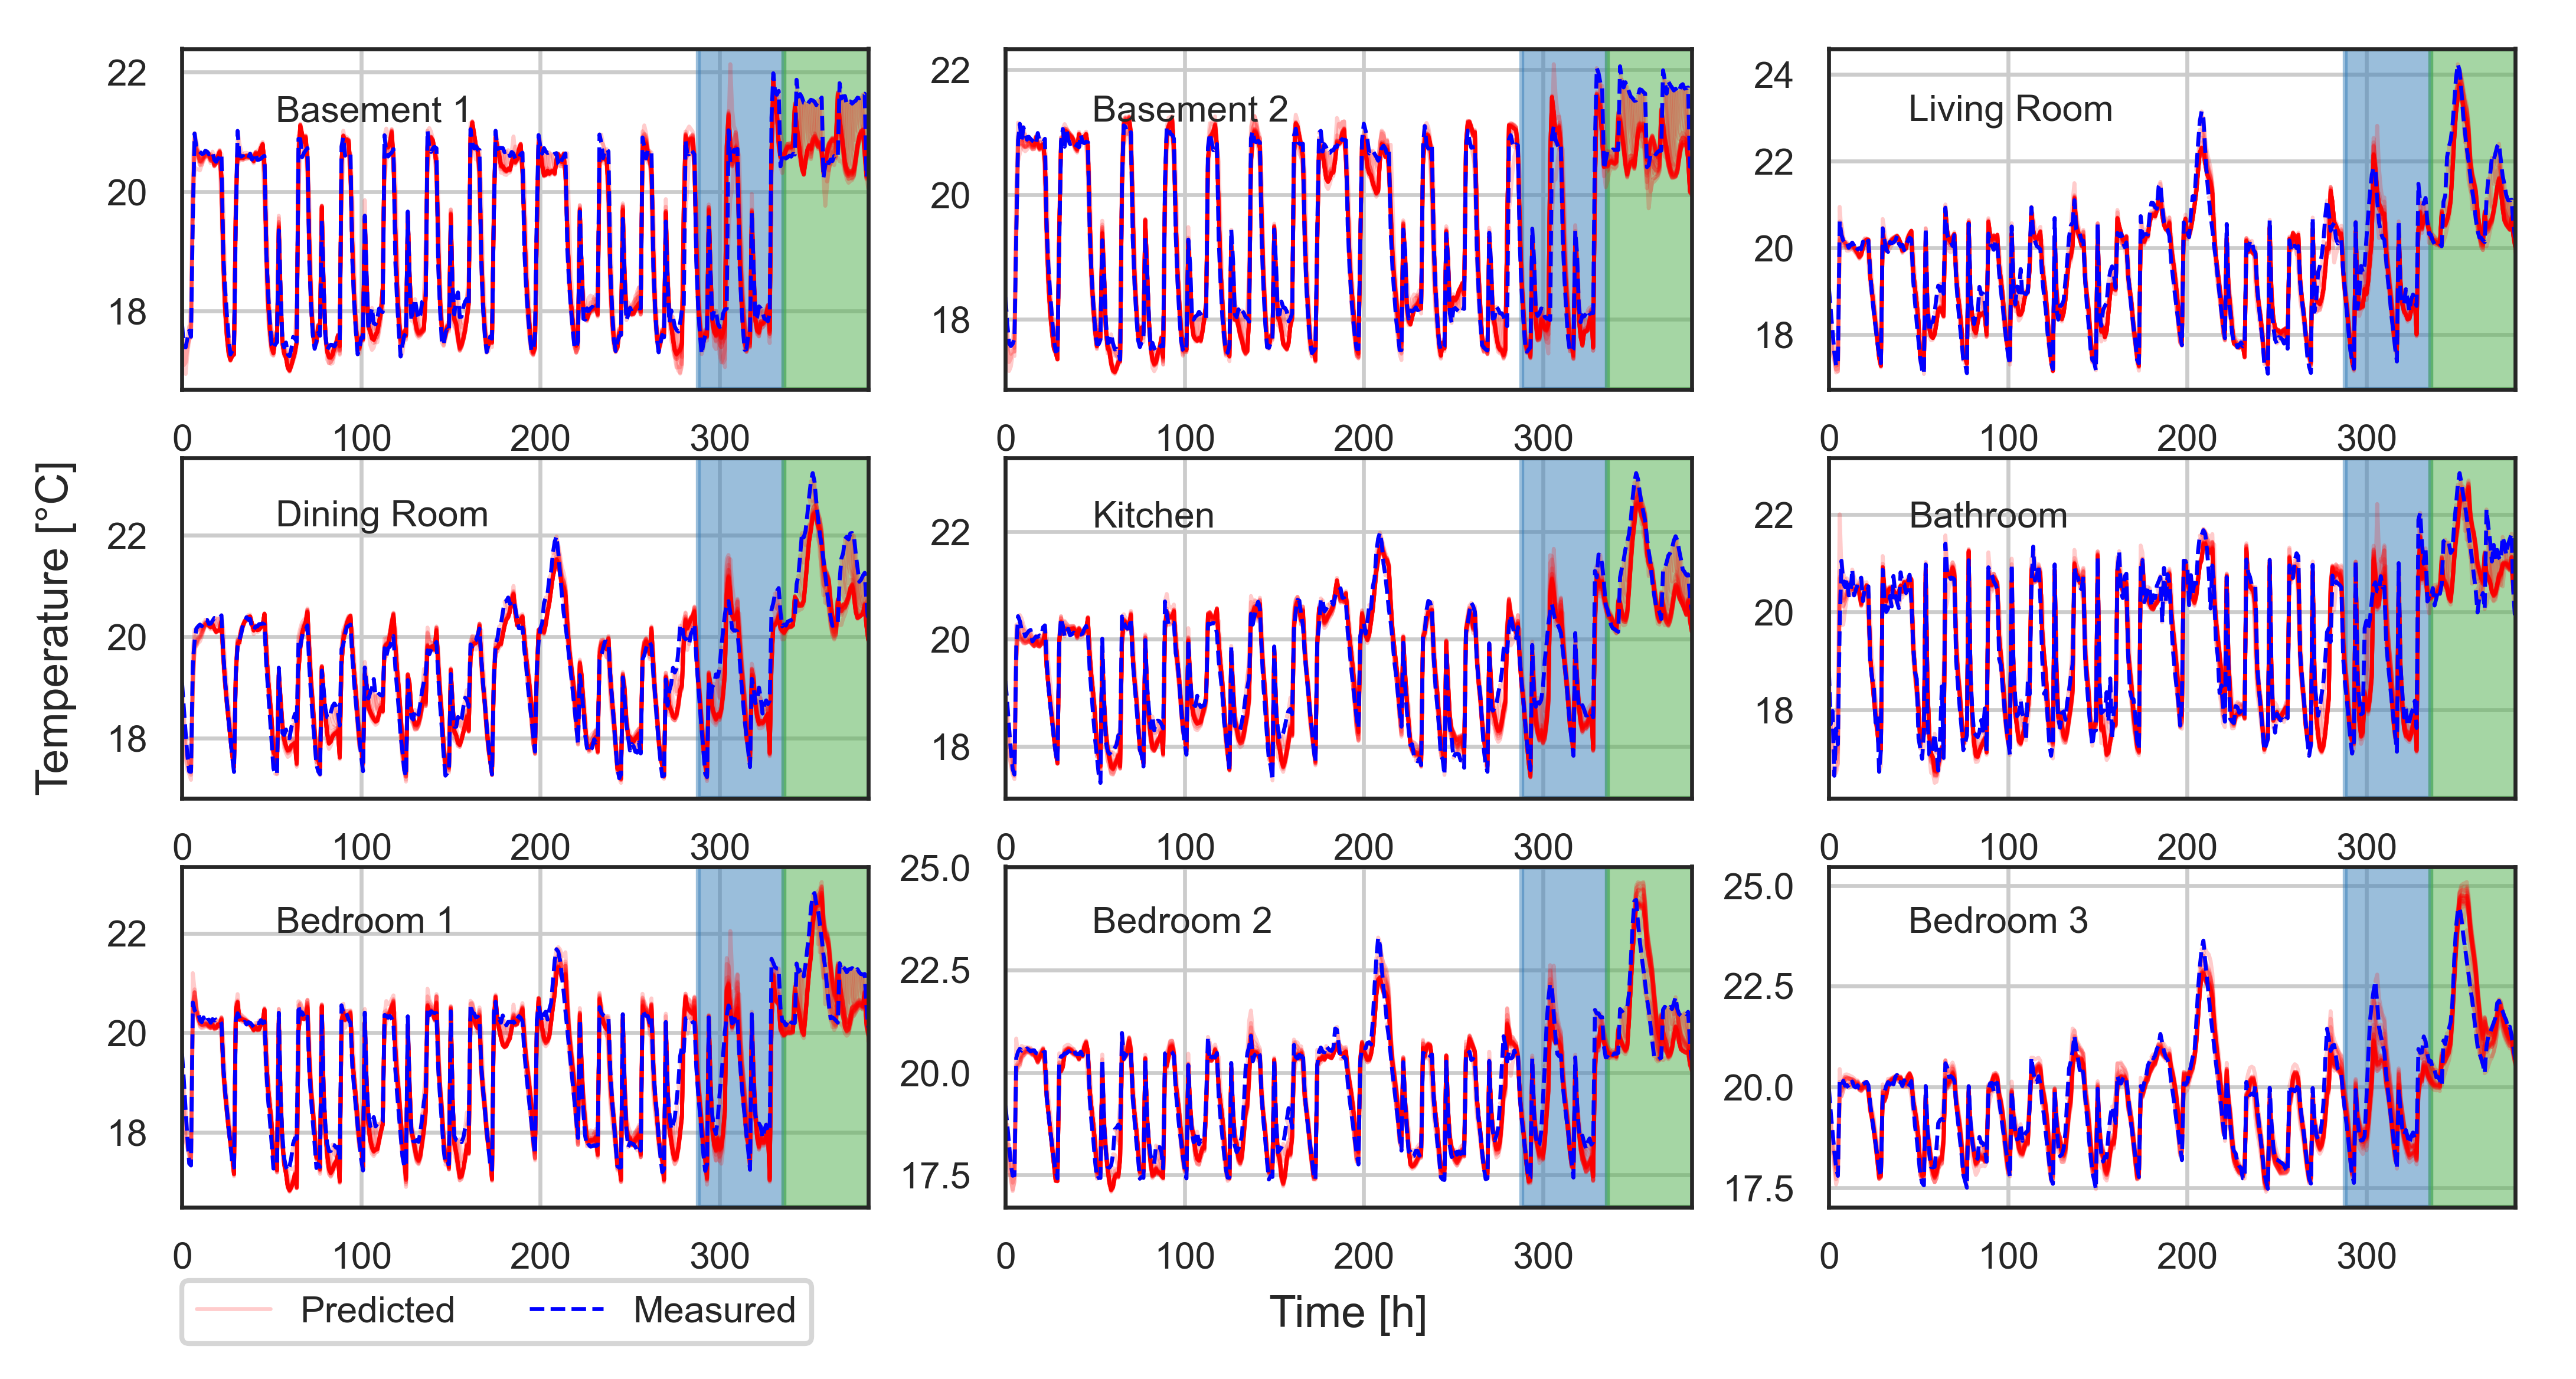

In [46]:
measured_Real = xn_df.iloc[::24].copy().reset_index(drop=True)
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 600

BIGGER_SIZE = 7.5
BIGGEST_SIZE = 9

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGEST_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

fig = plt.figure(figsize=(8.5,8.5/2))
ax = fig.add_subplot(111)
ax1 = fig.add_subplot(331)
ax2 = fig.add_subplot(332)
ax3 = fig.add_subplot(333)
ax4 = fig.add_subplot(334)
ax5 = fig.add_subplot(335)
ax6 = fig.add_subplot(336)
ax7 = fig.add_subplot(337)
ax8 = fig.add_subplot(338)
ax9 = fig.add_subplot(339)


ax_dict = {'ax1' : ax1,
           'ax2' : ax2,
           'ax3' : ax3,
           'ax4' : ax4,
           'ax5' : ax5,
           'ax6' : ax6,
           'ax7' : ax7,
           'ax8' : ax8,
           'ax9' : ax9,
            }

names_arr = ['Basement 1', 'Basement 2', 'Living Room', 'Dining Room', 'Kitchen', 'Bathroom', 'Bedroom 1', 'Bedroom 2', 'Bedroom 3']
names_pos_arr = [[0.05,0.95], [0.05,0.95], 'Living Room', 'Dining Room', 'Kitchen', 'Bathroom', 'Bedroom 1', 'Bedroom 2', 'Bedroom 3']

ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)
ax.set_xlabel('Time [h]')
ax.set_ylabel('Temperature [°C]')

for i in range(1,10):
    
    for j in range(0,len(measured_Real)):
        if j+i == 1:
            ax_dict[f'ax{i}'].plot(range(j,j+24),xn_df[f'T_{i}_NODE'][j*24:(j+1)*24],color='red',alpha=0.2,label=f'Predicted',linewidth=.8)
        else:
            ax_dict[f'ax{i}'].plot(range(j,j+24),xn_df[f'T_{i}_NODE'][j*24:(j+1)*24],color='red',alpha=0.2,linewidth=.8)
    ax_dict[f'ax{i}'].plot(measured_Real[f'T_{i}_Real'],'--',color='blue',label=f'Measured',linewidth=.8)

    
    ax_dict[f'ax{i}'].grid()
    ax_dict[f'ax{i}'].set_xlim(0,383)
    ax_dict[f'ax{i}'].text(0.04+0.35*((i-1)%3), 0.96-0.35*((i-1)//3), names_arr[i-1], transform=ax.transAxes, fontsize=BIGGER_SIZE, verticalalignment='top',)
    ax_dict[f'ax{i}'].axvspan(288,336,color='#377eb8',alpha=0.5)
    ax_dict[f'ax{i}'].axvspan(336,385,color='#4daf4a',alpha=0.5)

    if i == 1:    
        ax_dict[f'ax{i}'].legend(ncols=2,loc=[0,0],bbox_to_anchor=[0,-2.8])


In [47]:
train_valid_error_df = pd.DataFrame()
for i in range(1,10):
    train_valid_error_df[f'T_{i}'] = xn_df[f'T_{i}_NODE'][:6636] - xn_df[f'T_{i}_Real'][:6636]
train_valid_error_df = train_valid_error_df.dropna()
labels = ['Basement 1', 'Basement 2', 'Living Room', 'Dining Room', 'Kitchen', 'Bathroom', 'Bedroom 1', 'Bedroom 2', 'Bedroom 3']
train_valid_error_df.columns = labels

test1_error_df = pd.DataFrame()
for i in range(1,10):
    test1_error_df[f'T_{i}'] = xn_df[f'T_{i}_NODE'][6636:7788] - xn_df[f'T_{i}_Real'][6636:7788]
test1_error_df = test1_error_df.dropna()
labels = ['Basement 1', 'Basement 2', 'Living Room', 'Dining Room', 'Kitchen', 'Bathroom', 'Bedroom 1', 'Bedroom 2', 'Bedroom 3']
test1_error_df.columns = labels

test2_error_df = pd.DataFrame()
for i in range(1,10):
    test2_error_df[f'T_{i}'] = xn_df[f'T_{i}_NODE'][7788:] - xn_df[f'T_{i}_Real'][7788:]
test2_error_df = test2_error_df.dropna()
labels = ['Basement 1', 'Basement 2', 'Living Room', 'Dining Room', 'Kitchen', 'Bathroom', 'Bedroom 1', 'Bedroom 2', 'Bedroom 3']
test2_error_df.columns = labels

rank = []
for i in range(0,len(train_valid_error_df)):
    rank.append('Training/Validation')

train_valid_error_df['Rank'] = rank

rank = []
for i in range(0,len(test1_error_df)):
    rank.append('Testing 1')

test1_error_df['Rank'] = rank


rank = []
for i in range(0,len(test2_error_df)):
    rank.append('Testing 2')

test2_error_df['Rank'] = rank

error_df = pd.concat([train_valid_error_df,test1_error_df,test2_error_df])
error_df_long = pd.melt(error_df, id_vars='Rank', value_vars=['Basement 1', 'Basement 2', 'Living Room', 'Dining Room', 'Kitchen', 'Bathroom', 'Bedroom 1', 'Bedroom 2', 'Bedroom 3'])
error_df_long.columns = ['Dataset', 'Zone', 'Error [°C]']

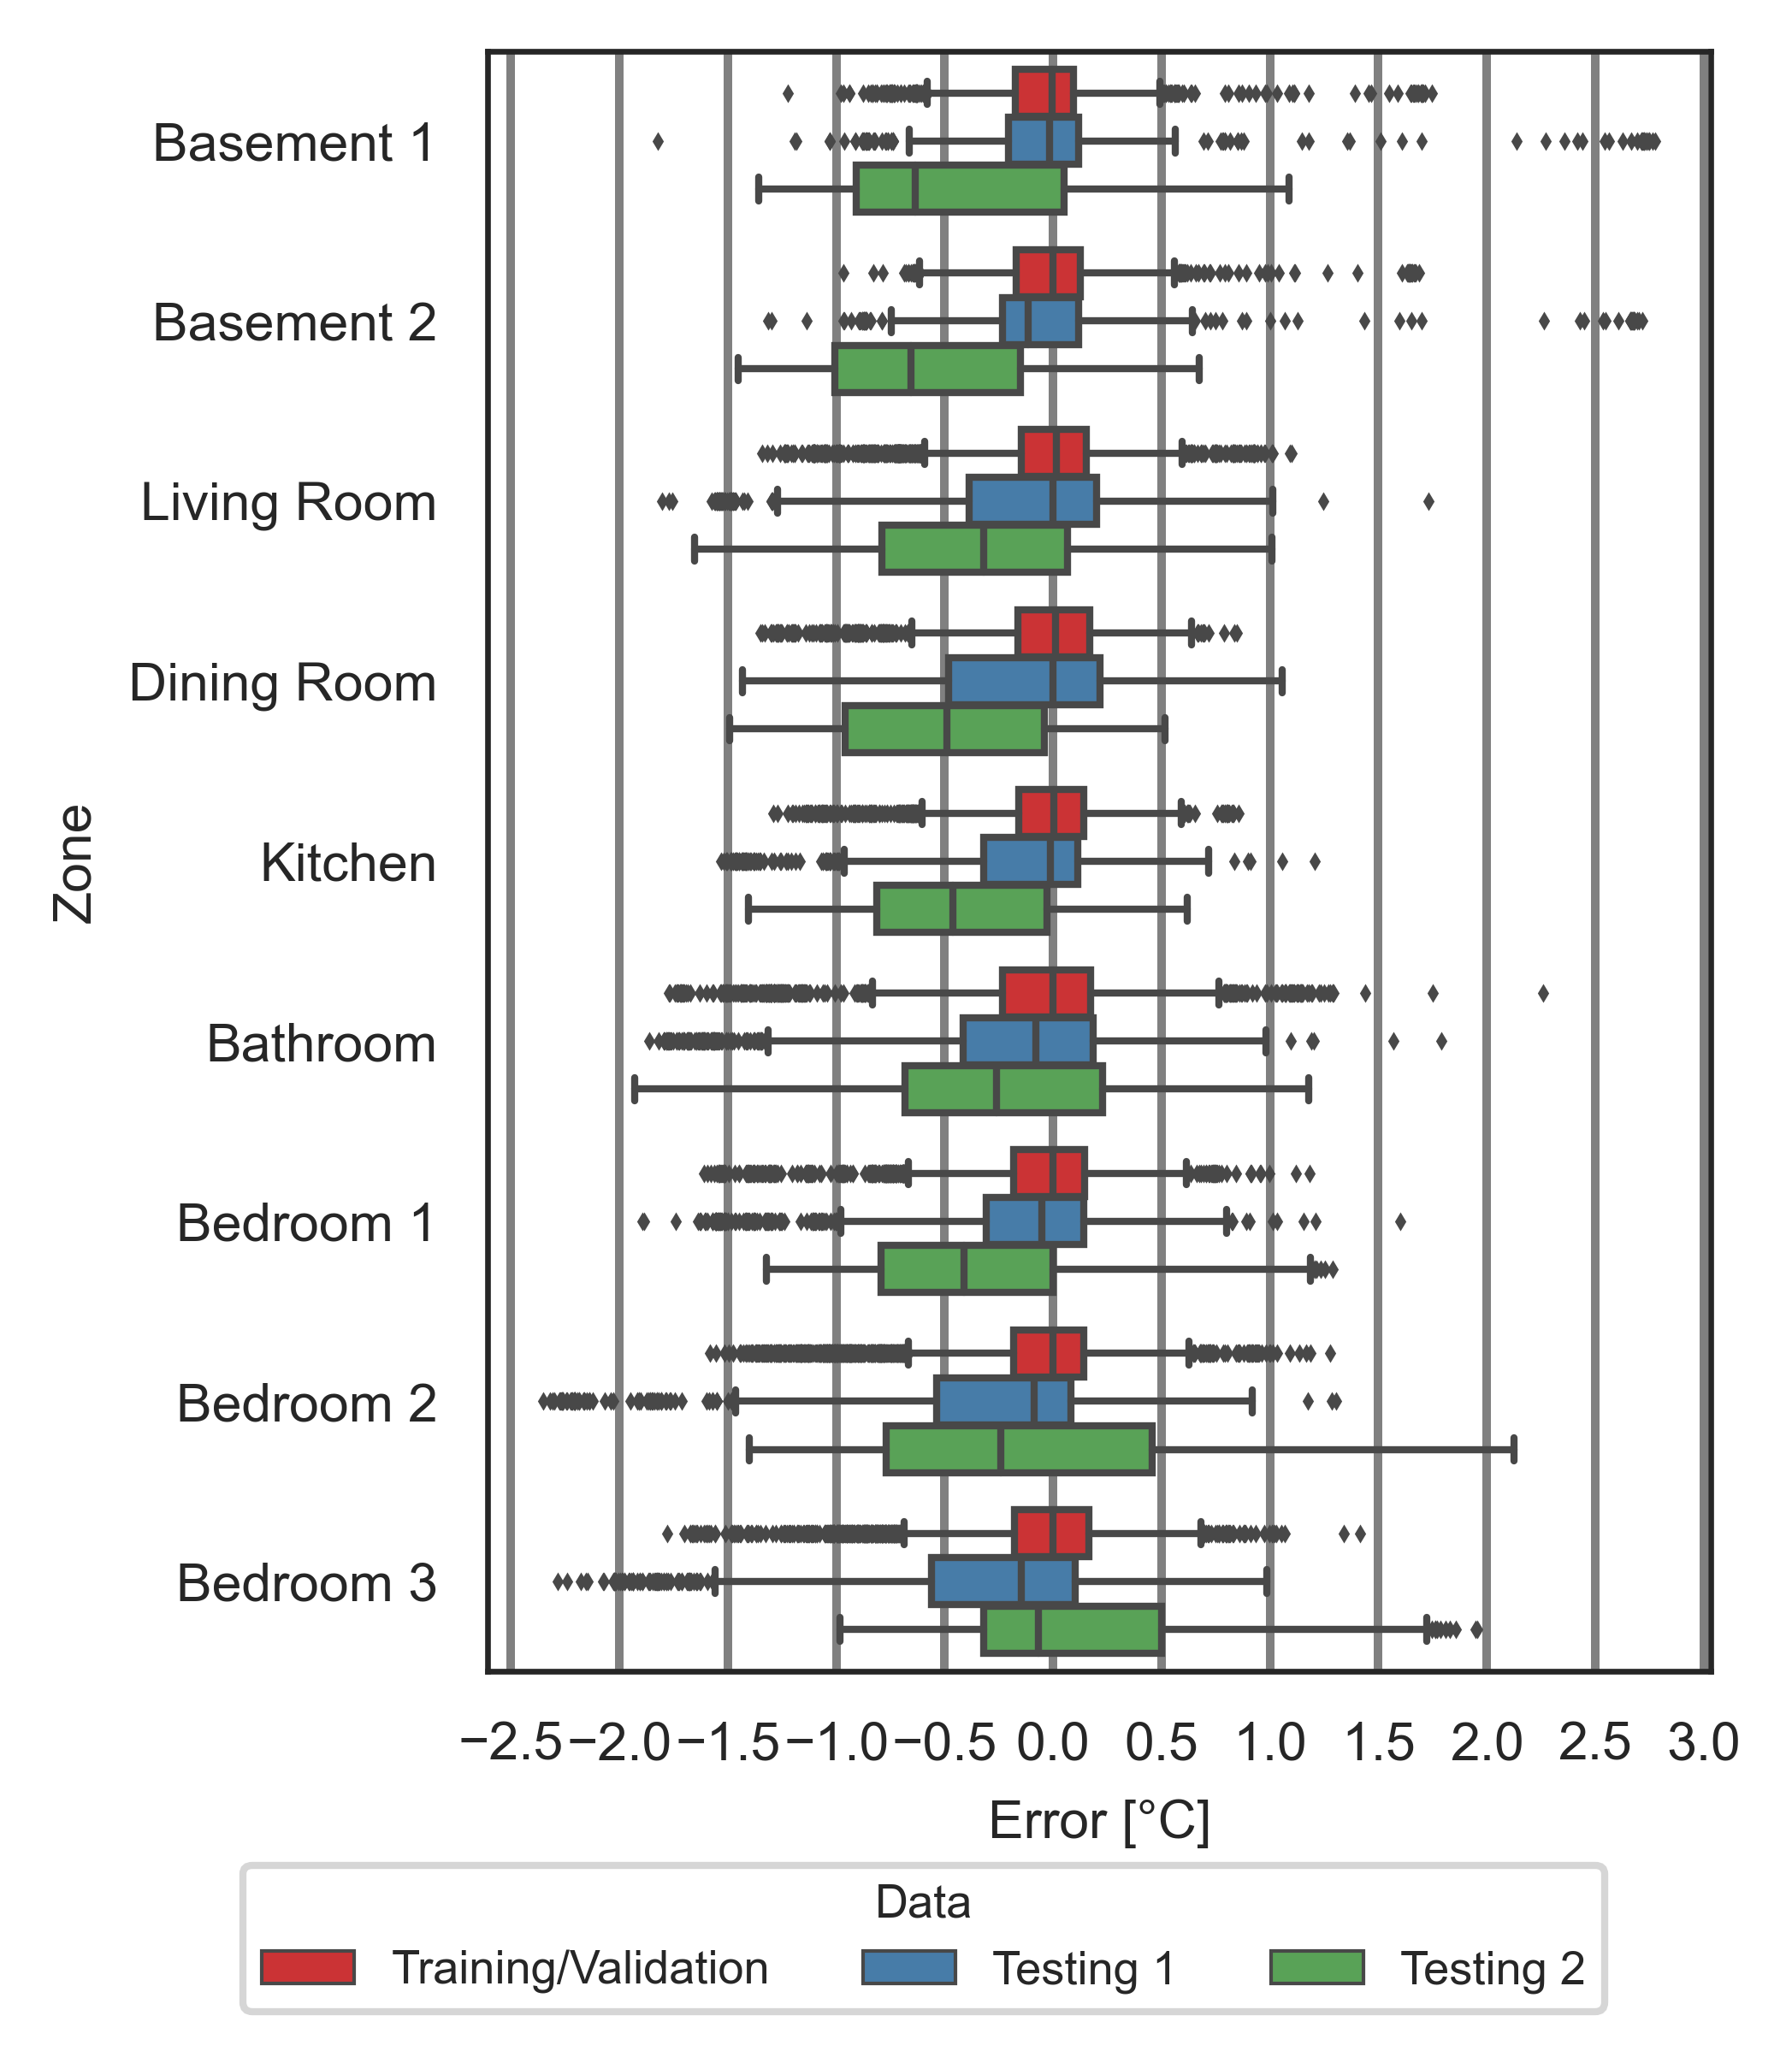

In [48]:
sns.set_style("white")
sns.set_palette('Set1')
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 600
mpl.rcParams['figure.figsize'] = 8.5*8.16/17.59*0.78,8.5*8.16/17.59*8/6*0.78
fig, ax = plt.subplots(nrows=1, ncols=1)


plt.rc('font', size=BIGGER_SIZE-1)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE-1.5)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE-1)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE-1)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

bplot = sns.boxplot(y="Zone",
            x="Error [°C]",
            hue="Dataset",
            data=error_df_long,
            palette="Set1",
            fliersize=0.5,
            ax=ax,
            linewidth=1.,

            )
bplot.set_xlabel("Error [°C]",fontsize=BIGGER_SIZE)
bplot.set_ylabel("Zone",fontsize=BIGGER_SIZE)

plt.xticks(np.arange(-2.5, 3.5, step=0.5))
ax.grid(b=True, which='major', axis='x', color='gray', linewidth=1.2)
plt.legend(ncols=3, title='Data',loc=[-0.2,-0.21])

plt.show()